# 🎯 재채기 탐지 경량화 모델

## 목표
- Raspberry Pi / Jetson Nano 등 임베디드 시스템에서 실시간 처리 가능한 경량 모델
- 개선된 Negative 샘플 (생활 소음)
- 데이터 증강으로 성능 향상
- MFCC 기반 효율적 특징 추출

## 파이프라인
1. 데이터 재구성 (생활 소음 중심 Negative 샘플)
2. 데이터 증강
3. PyTorch Dataset/DataLoader
4. 경량 CNN 모델
5. 학습 및 평가

## 1. 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import polars as pl
import torchaudio

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib
import random
import os

# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 디바이스 설정
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device("cpu")
print(f"Using device: {device}")

# 경로 설정
ESC50_AUDIO_PATH = "./esc-50/audio/"
ESC50_META_PATH = "./esc-50/meta/esc50.csv"
SNEEZE_AUDIO_PATH = "./datasets/"
SCENE_NOISE_PATH = "./1297-Hours-Scene-Noise-Data-by-Voice-Recorder/"
SNSD_NOISE_PATH = "./MS-SNSD-NOISE"
MODEL_SAVE_PATH = "./models/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"Available datasets:")
print(f"  ✓ ESC-50: {ESC50_AUDIO_PATH}")
print(f"  ✓ Sneeze: {SNEEZE_AUDIO_PATH}")
print(f"  ✓ Scene Noise: {SCENE_NOISE_PATH}")
print(f"  ✓ MS-SNSD Noise: {SNSD_NOISE_PATH}")

matplotlib.rcParams['font.family'] = 'AppleGothic' # 맥
matplotlib.rcParams['axes.unicode_minus'] = False

Using device: cpu
Available datasets:
  ✓ ESC-50: ./esc-50/audio/
  ✓ Sneeze: ./datasets/
  ✓ Scene Noise: ./1297-Hours-Scene-Noise-Data-by-Voice-Recorder/
  ✓ MS-SNSD Noise: ./MS-SNSD-NOISE


## 2. ESC-50 데이터셋 분석 및 카테고리 선택

In [2]:
# ESC-50 메타데이터 로드
desc_csv = pl.read_csv(ESC50_META_PATH)

# 생활 소음 관련 카테고리 정의
LIFE_NOISE_CATEGORIES = [
    'coughing', 'breathing', 'laughing', 'crying_baby',
    'footsteps', 'door_wood_knock', 'clapping',
    'keyboard_typing', 'drinking_sipping', 'brushing_teeth',
]

# 존재하는 카테고리만 필터링
all_categories = desc_csv['category'].unique().to_list()
LIFE_NOISE_CATEGORIES = [cat for cat in LIFE_NOISE_CATEGORIES if cat in all_categories]

print(f"선택된 생활 소음 카테고리 ({len(LIFE_NOISE_CATEGORIES)}개):")
for cat in LIFE_NOISE_CATEGORIES:
    count = len(desc_csv.filter(pl.col('category') == cat))
    print(f"  - {cat}: {count} samples")

선택된 생활 소음 카테고리 (10개):
  - coughing: 40 samples
  - breathing: 40 samples
  - laughing: 40 samples
  - crying_baby: 40 samples
  - footsteps: 40 samples
  - door_wood_knock: 40 samples
  - clapping: 40 samples
  - keyboard_typing: 40 samples
  - drinking_sipping: 40 samples
  - brushing_teeth: 40 samples


## 3. 데이터 로딩 함수

In [3]:
# 🔍 Scene Noise 데이터 분석 (샘플링 길이 확인)
print("=" * 70)
print("🔍 Scene Noise 데이터셋 분석")
print("=" * 70)

if os.path.exists(SCENE_NOISE_PATH):
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    files = []
    
    for root, dirs, filenames in os.walk(SCENE_NOISE_PATH):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if files:
        print(f"\n📊 총 오디오 파일 수: {len(files)}")
        
        # 샘플링 길이 분석 (처음 20개 샘플)
        sample_sizes = []
        durations = []
        
        print(f"\n샘플 길이 분석 (처음 20개 파일):")
        print(f"{'파일명':<40} {'SR':<8} {'Duration':<12} {'Frame':<10}")
        print("-" * 70)
        
        for i, file_path in enumerate(files[:20]):
            try:
                audio, sr = torchaudio.load(file_path)
                duration = audio.shape[1] / sr
                sample_sizes.append(duration)
                durations.append(duration)
                
                filename = os.path.basename(file_path)
                print(f"{filename:<40} {sr:<8} {duration:<12.2f}s {audio.shape[1]:<10}")
            except Exception as e:
                print(f"{os.path.basename(file_path):<40} ERROR: {str(e)[:30]}")
        
        if sample_sizes:
            print(f"\n📈 길이 통계:")
            print(f"  평균: {np.mean(sample_sizes):.2f}초")
            print(f"  최소: {np.min(sample_sizes):.2f}초")
            print(f"  최대: {np.max(sample_sizes):.2f}초")
            print(f"  중앙값: {np.median(sample_sizes):.2f}초")
            
            # 길이 분포
            duration_ranges = {
                "~1초": sum(1 for d in durations if d < 1.5),
                "1-2초": sum(1 for d in durations if 1.5 <= d < 2.5),
                "2-5초": sum(1 for d in durations if 2.5 <= d < 5.5),
                "5-10초": sum(1 for d in durations if 5.5 <= d < 10.5),
                "10초+": sum(1 for d in durations if d >= 10.5),
            }
            
            print(f"\n📊 길이 분포 (처음 20개 샘플 기준):")
            for range_name, count in duration_ranges.items():
                print(f"  {range_name}: {count}개")
    else:
        print(f"\n⚠️  Scene Noise 폴더에 오디오 파일이 없습니다.")
        print(f"   경로: {SCENE_NOISE_PATH}")
else:
    print(f"\n⚠️  Scene Noise 경로가 존재하지 않습니다: {SCENE_NOISE_PATH}")
    print(f"   데이터셋을 다운로드하고 경로를 설정하세요.")

print("\n💡 현재 로드 설정: target_length=32000 (16kHz에서 2초)")
print("=" * 70)


🔍 Scene Noise 데이터셋 분석

📊 총 오디오 파일 수: 30

샘플 길이 분석 (처음 20개 파일):
파일명                                      SR       Duration     Frame     
----------------------------------------------------------------------
G0002_P0001_01.wav                       44100    10.00       s 441000    
G0006_P0006_01.wav                       44100    10.00       s 441000    
G0001_P0006_01.wav                       44100    10.61       s 468101    
G0002_P0003_01.wav                       44100    10.00       s 441000    
G0005_P0003_01.wav                       44100    11.15       s 491505    
G0005_P0011_01.wav                       44100    10.00       s 441000    
G0001_P0004_01.wav                       44100    10.00       s 441000    
G0006_P0004_01.wav                       44100    10.00       s 441000    
G0002_P0007_01.wav                       44100    10.00       s 441000    
G0005_P0007_01.wav                       44100    10.00       s 441000    
G0006_P0002_01.wav                       4

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

  중앙값: 10.00초

📊 길이 분포 (처음 20개 샘플 기준):
  ~1초: 0개
  1-2초: 0개
  2-5초: 0개
  5-10초: 18개
  10초+: 2개

💡 현재 로드 설정: target_length=32000 (16kHz에서 2초)


In [4]:
def load_audio(file_path, target_sr=16000, target_length=32000):
    """
    오디오 파일 로드 및 전처리
    - Sampling rate를 target_sr로 자동 조정
    - 길이를 target_length로 통일
    """
    audio, sr = torchaudio.load(file_path)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        audio = resampler(audio)
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    if audio.shape[1] > target_length:
        audio = audio[:, :target_length]
    elif audio.shape[1] < target_length:
        audio = F.pad(audio, (0, target_length - audio.shape[1]))
    return audio.numpy().flatten()

def load_sneeze_dataset(audio_path):
    """재채기 음성 데이터 로드"""
    files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
    dataset = []
    for f in tqdm(files, desc="Sneeze"):
        dataset.append(load_audio(os.path.join(audio_path, f)))
    return dataset

def load_life_noise_dataset(esc_path, meta_path, categories, max_samples=None):
    """ESC-50 생활 소음 데이터 로드"""
    csv = pl.read_csv(meta_path)
    filtered = csv.filter(pl.col('category').is_in(categories))
    if max_samples and len(filtered) > max_samples:
        filtered = filtered.sample(n=max_samples, seed=SEED)
    dataset = []
    for row in tqdm(filtered.iter_rows(), total=len(filtered), desc="Life Noise (ESC-50)"):
        dataset.append(load_audio(os.path.join(esc_path, row[0])))
    return dataset

def load_scene_noise_dataset(scene_noise_path, max_samples=None, target_sr=16000, target_length=32000):
    """
    1297-Hours Scene Noise 데이터셋 로드 및 분할
    - 10초 오디오 파일을 2초(target_length) 단위로 잘라서 로드
    - Sampling rate 자동 조정 및 Mono 변환 포함
    """
    if not os.path.exists(scene_noise_path):
        print(f"⚠️  경고: Scene Noise 경로 없음 - {scene_noise_path}")
        return []
    
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    files = []
    for root, _, filenames in os.walk(scene_noise_path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if not files:
        print(f"⚠️  경고: Scene Noise 폴더에 오디오 파일 없음 - {scene_noise_path}")
        return []

    # 파일 목록을 미리 섞어서 다양성 확보
    random.shuffle(files)
    
    dataset = []
    failed_count = 0
    
    for file_path in tqdm(files, desc="Processing Scene Noise"):
        try:
            # 1. 오디오 로드 및 기본 전처리
            audio, sr = torchaudio.load(file_path)
            
            # 리샘플링
            if sr != target_sr:
                resampler = torchaudio.transforms.Resample(sr, target_sr)
                audio = resampler(audio)
            
            # Mono 변환 (채널 평균)
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # 2. 2초(target_length) 단위로 슬라이싱
            # audio.shape[1]은 전체 샘플 수 (예: 10초 = 160,000)
            total_samples = audio.shape[1]
            
            for start in range(0, total_samples - target_length + 1, target_length):
                segment = audio[:, start : start + target_length]
                dataset.append(segment.numpy().flatten())
                
                # 목표 샘플 수(max_samples)에 도달하면 즉시 중단
                if max_samples and len(dataset) >= max_samples:
                    return dataset

        except Exception as e:
            failed_count += 1
            if failed_count <= 3:
                print(f"  ⚠️  로드 실패: {file_path} - {str(e)[:50]}")
    
    if failed_count > 0:
        print(f"  (총 {failed_count}개 파일 처리 중 오류 발생)")
    
    return dataset

def load_ms_snsd_dataset(snsd_path, max_samples=None, target_sr=16000, target_length=32000):
    """
    Microsoft MS-SNSD 데이터셋 로드 및 분할
    - 소음(noise) 폴더 내의 파일들을 2초 단위로 분할
    """
    if not os.path.exists(snsd_path):
        print(f"⚠️  경고: MS-SNSD 경로 없음 - {snsd_path}")
        return []
    
    # MS-SNSD는 보통 .wav 형식을 사용합니다.
    audio_extensions = ['.wav']
    files = []
    for root, _, filenames in os.walk(snsd_path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in audio_extensions):
                files.append(os.path.join(root, filename))
    
    if not files:
        print(f"⚠️  경고: MS-SNSD 폴더에 .wav 파일 없음 - {snsd_path}")
        return []

    random.shuffle(files)
    
    dataset = []
    failed_count = 0
    
    for file_path in tqdm(files, desc="Processing MS-SNSD"):
        try:
            audio, sr = torchaudio.load(file_path)
            
            # 리샘플링 및 모노 변환
            if sr != target_sr:
                resampler = torchaudio.transforms.Resample(sr, target_sr)
                audio = resampler(audio)
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # 2초 단위 슬라이싱
            total_samples = audio.shape[1]
            for start in range(0, total_samples - target_length + 1, target_length):
                segment = audio[:, start : start + target_length]
                dataset.append(segment.numpy().flatten())
                
                if max_samples and len(dataset) >= max_samples:
                    return dataset

        except Exception as e:
            failed_count += 1
            if failed_count <= 3:
                print(f"  ⚠️  로드 실패: {file_path} - {str(e)[:50]}")
    
    return dataset

# 데이터 로드
print("=" * 70)
print("🎵 데이터 로딩 시작")
print("=" * 70)

# 1. 재채기 데이터
sneeze_samples = load_sneeze_dataset(SNEEZE_AUDIO_PATH)
print(f"\n✓ Sneeze: {len(sneeze_samples)} 샘플")

# 2. ESC-50 생활 소음
life_noise_samples = load_life_noise_dataset(
    ESC50_AUDIO_PATH, ESC50_META_PATH, LIFE_NOISE_CATEGORIES,
    # max_samples=len(sneeze_samples)
)
print(f"✓ Life Noise (ESC-50): {len(life_noise_samples)} 샘플")

# 3. Scene Noise (선택적)
scene_noise_samples = load_scene_noise_dataset(
    SCENE_NOISE_PATH,
    max_samples=len(sneeze_samples) * 2  # Sneeze의 2배까지 로드
)

snsd_samples = load_ms_snsd_dataset(
    SNSD_NOISE_PATH,
    max_samples=len(sneeze_samples) * 2 # Sneeze의 2배 정도 권장
)

if scene_noise_samples:
    print(f"✓ Scene Noise (1297-Hours): {len(scene_noise_samples)} 샘플")
    # ESC-50과 Scene Noise 결합
    all_negative_samples = life_noise_samples + scene_noise_samples + snsd_samples
    print(f"\n✅ 총 Negative 샘플: {len(all_negative_samples)} (ESC-50 {len(life_noise_samples)} + Scene {len(scene_noise_samples)} + SNSD {len(snsd_samples)})")
else:
    all_negative_samples = life_noise_samples
    print(f"\n✅ 총 Negative 샘플: {len(all_negative_samples)} (ESC-50만 사용)")

print(f"   Positive (Sneeze): {len(sneeze_samples)}")
print("=" * 70)

🎵 데이터 로딩 시작


Sneeze: 100%|██████████| 968/968 [00:03<00:00, 263.12it/s]



✓ Sneeze: 968 샘플


Life Noise (ESC-50): 100%|██████████| 400/400 [00:03<00:00, 122.08it/s]


✓ Life Noise (ESC-50): 400 샘플


Processing MS-SNSD:  27%|██▋       | 34/128 [00:00<00:01, 59.89it/s]

✓ Scene Noise (1297-Hours): 150 샘플

✅ 총 Negative 샘플: 2486 (ESC-50 400 + Scene 150 + SNSD 1936)
   Positive (Sneeze): 968


## 4. 데이터 증강

In [5]:
from scipy import signal

# 🎵 기본 증강 기법들
def time_stretch(audio, rate_range=(0.8, 1.2)):
    """시간 스트레칭 - 빠르기 조절"""
    rate = np.random.uniform(*rate_range)
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    if len(stretched) > len(audio):
        return stretched[:len(audio)]
    else:
        return np.pad(stretched, (0, len(audio) - len(stretched)))

def pitch_shift(audio, sr=16000, n_steps_range=(-3, 3)):
    """피치 시프트 - 음높이 조절"""
    n_steps = np.random.uniform(*n_steps_range)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor_range=(0.002, 0.01)):
    """가우시안 노이즈 추가"""
    factor = np.random.uniform(*noise_factor_range)
    return audio + factor * np.random.randn(len(audio))

def time_shift(audio, shift_range=(-0.2, 0.2)):
    """시간 시프트 - 신호를 이동"""
    shift = int(np.random.uniform(*shift_range) * len(audio))
    return np.roll(audio, shift)

# 🎵 고급 증강 기법들
def volume_shift(audio, gain_range=(0.7, 1.3)):
    """볼륨/에너지 조절"""
    gain = np.random.uniform(*gain_range)
    return audio * gain

def dynamic_range_compression(audio, threshold=0.1, ratio=4.0):
    """다이나믹 레인지 압축 (강한 신호만 더 강하게)"""
    compressed = audio.copy()
    mask = np.abs(audio) > threshold
    compressed[mask] = np.sign(audio[mask]) * (threshold + (np.abs(audio[mask]) - threshold) / ratio)
    return compressed

def low_pass_filter(audio, sr=16000, cutoff_freq=4000):
    """저역통과 필터 - 높은 음역 감소"""
    nyquist = sr / 2
    normalized_cutoff = cutoff_freq / nyquist
    normalized_cutoff = np.clip(normalized_cutoff, 0.01, 0.99)
    b, a = signal.butter(5, normalized_cutoff, btype='low')
    return signal.filtfilt(b, a, audio)

def high_pass_filter(audio, sr=16000, cutoff_freq=500):
    """고역통과 필터 - 낮은 음역 감소"""
    nyquist = sr / 2
    normalized_cutoff = cutoff_freq / nyquist
    normalized_cutoff = np.clip(normalized_cutoff, 0.01, 0.99)
    b, a = signal.butter(5, normalized_cutoff, btype='high')
    return signal.filtfilt(b, a, audio)

def time_mask(audio, mask_ratio=0.1):
    """시간 마스킹 - 일부 시간대 음소거"""
    mask_length = int(len(audio) * mask_ratio)
    start = np.random.randint(0, len(audio) - mask_length)
    audio_masked = audio.copy()
    audio_masked[start:start+mask_length] = 0
    return audio_masked

def frequency_mask_via_librosa(audio, sr=16000, n_mels=128):
    """스펙트럼 마스킹 - 특정 주파수대 억제"""
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    # 랜덤하게 주파수 대역 마스킹
    num_freq_masks = np.random.randint(1, 3)
    for _ in range(num_freq_masks):
        f = np.random.randint(0, n_mels // 4)
        f0 = np.random.randint(0, n_mels - f)
        S[f0:f0+f, :] = S[f0:f0+f, :] * np.random.uniform(0.3, 1.0)
    
    # Mel-spectrogram을 다시 음성으로 복원 (근사)
    # 간단히 원본 신호에 slight 변형 가함
    return audio * np.random.uniform(0.9, 1.0)

def add_background_noise(audio, noise_type='white', sr=16000, noise_factor=0.005):
    """백그라운드 노이즈 추가"""
    if noise_type == 'white':
        noise = np.random.randn(len(audio))
    elif noise_type == 'pink':
        # 핑크 노이즈: 저주파 강조
        white = np.random.randn(len(audio))
        b, a = signal.butter(1, 0.1)
        noise = signal.filtfilt(b, a, white)
        noise = noise / np.max(np.abs(noise))
    else:
        noise = np.random.randn(len(audio))
    
    return audio + noise_factor * noise

def echo_effect(audio, delay=0.05, decay=0.5, sr=16000):
    """에코 효과 추가"""
    delay_samples = int(delay * sr)
    if delay_samples >= len(audio):
        return audio
    
    echo_audio = audio.copy()
    echo_audio[delay_samples:] += decay * audio[:-delay_samples]
    return np.clip(echo_audio, -1, 1)

def random_eq_boost(audio, sr=16000):
    """랜덤 이퀄라이저 부스트 - 특정 주파수 강조"""
    boost_freq = np.random.choice([500, 1000, 2000, 4000, 8000])
    Q = np.random.uniform(0.5, 2.0)
    gain = np.random.uniform(1.5, 3.0)
    
    # 간단한 부스트: 해당 주파수 근처 강조
    nyquist = sr / 2
    w = 2 * np.pi * boost_freq / sr
    
    # 이차 필터 설계
    b = [gain * np.sin(w/2), 0, -gain * np.sin(w/2)]
    a = [1 + np.sin(w/2)/Q, -2*np.cos(w), 1 - np.sin(w/2)/Q]
    
    try:
        result = signal.filtfilt(b, a, audio)
        return np.clip(result, -1, 1)
    except:
        return audio

def combination_augment(audio):
    """여러 기법 조합 증강"""
    augmented = audio.copy()
    
    # 무작위로 2-3개 기법 조합
    num_augments = np.random.randint(2, 4)
    augment_methods = [
        lambda x: time_stretch(x),
        lambda x: pitch_shift(x),
        lambda x: volume_shift(x),
        lambda x: add_noise(x),
        lambda x: time_shift(x),
        lambda x: dynamic_range_compression(x),
        lambda x: low_pass_filter(x),
        lambda x: high_pass_filter(x),
        lambda x: add_background_noise(x),
        lambda x: echo_effect(x),
    ]
    
    selected_methods = np.random.choice(len(augment_methods), num_augments, replace=False)
    for idx in selected_methods:
        try:
            augmented = augment_methods[idx](augmented)
        except:
            pass  # 증강 실패 시 무시
    
    return augmented

def augment_audio(audio):
    """단일 증강 기법 선택"""
    aug_type = np.random.choice([
        'time_stretch', 'pitch_shift', 'add_noise', 'time_shift',
        'volume_shift', 'compression', 'low_pass', 'high_pass',
        'time_mask', 'background_noise', 'echo', 'eq_boost', 'combination'
    ])
    
    try:
        if aug_type == 'time_stretch':
            return time_stretch(audio)
        elif aug_type == 'pitch_shift':
            return pitch_shift(audio)
        elif aug_type == 'add_noise':
            return add_noise(audio)
        elif aug_type == 'time_shift':
            return time_shift(audio)
        elif aug_type == 'volume_shift':
            return volume_shift(audio)
        elif aug_type == 'compression':
            return dynamic_range_compression(audio)
        elif aug_type == 'low_pass':
            return low_pass_filter(audio)
        elif aug_type == 'high_pass':
            return high_pass_filter(audio)
        elif aug_type == 'time_mask':
            return time_mask(audio)
        elif aug_type == 'background_noise':
            return add_background_noise(audio)
        elif aug_type == 'echo':
            return echo_effect(audio)
        elif aug_type == 'eq_boost':
            return random_eq_boost(audio)
        else:  # combination
            return combination_augment(audio)
    except:
        return audio

# 🔧 강화된 데이터 증강: 3배 이상 (통합 Negative 샘플 사용)
print("=" * 70)
print("🎵 강화된 데이터 증강 (다양한 기법 적용)")
print("=" * 70)

print("\n📊 증강 기법:")
print("  ✓ Time Stretch (속도 변화)")
print("  ✓ Pitch Shift (음높이 변화)")
print("  ✓ Noise Addition (노이즈 추가)")
print("  ✓ Time Shift (시간 이동)")
print("  ✓ Volume Shift (볼륨 조절)")
print("  ✓ Dynamic Range Compression (음역 압축)")
print("  ✓ Low-Pass Filter (저역 강조)")
print("  ✓ High-Pass Filter (고역 강조)")
print("  ✓ Time Masking (부분 음소거)")
print("  ✓ Background Noise (배경음)")
print("  ✓ Echo Effect (에코)")
print("  ✓ EQ Boost (주파수 강조)")
print("  ✓ Combination (기법 조합)")

# Sneeze 증강 (원본 수 기준)
sneeze_aug1 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-1")]
sneeze_aug2 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-2")]
sneeze_aug3 = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug-3")]

# Negative 증강 (통합된 샘플 사용: ESC-50 + Scene Noise)
neg_aug1 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-1")]
neg_aug2 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-2")]
neg_aug3 = [augment_audio(a) for a in tqdm(all_negative_samples, desc="Negative Aug-3")]

all_sneeze = sneeze_samples + sneeze_aug1 + sneeze_aug2 + sneeze_aug3
all_life_noise = all_negative_samples + neg_aug1 + neg_aug2 + neg_aug3

print("\n" + "=" * 70)
print(f"✅ 증강 완료!")
print(f"  Positive (Sneeze): {len(sneeze_samples)} → {len(all_sneeze)} (3배 증강)")
print(f"  Negative (Noise):  {len(all_negative_samples)} → {len(all_life_noise)} (3배 증강)")
print(f"  ")
print(f"  Negative 구성:")
if scene_noise_samples:
    print(f"    • ESC-50:        {len(life_noise_samples)} 샘플")
    print(f"    • Scene Noise:   {len(scene_noise_samples)} 샘플")
else:
    print(f"    • ESC-50:        {len(life_noise_samples)} 샘플 (Scene Noise 미사용)")
print(f"  ")
print(f"  총 샘플: {len(all_sneeze) + len(all_life_noise)}")
print("=" * 70)

🎵 강화된 데이터 증강 (다양한 기법 적용)

📊 증강 기법:
  ✓ Time Stretch (속도 변화)
  ✓ Pitch Shift (음높이 변화)
  ✓ Noise Addition (노이즈 추가)
  ✓ Time Shift (시간 이동)
  ✓ Volume Shift (볼륨 조절)
  ✓ Dynamic Range Compression (음역 압축)
  ✓ Low-Pass Filter (저역 강조)
  ✓ High-Pass Filter (고역 강조)
  ✓ Time Masking (부분 음소거)
  ✓ Background Noise (배경음)
  ✓ Echo Effect (에코)
  ✓ EQ Boost (주파수 강조)
  ✓ Combination (기법 조합)


Negative Aug-3: 100%|██████████| 2486/2486 [00:03<00:00, 723.38it/s]


✅ 증강 완료!
  Positive (Sneeze): 968 → 3872 (3배 증강)
  Negative (Noise):  2486 → 9944 (3배 증강)
  
  Negative 구성:
    • ESC-50:        400 샘플
    • Scene Noise:   150 샘플
  
  총 샘플: 13816


# 4-1. Signal Feature Analysis

**목표**: 현재 모델이 고주파 사운드(snap 등)를 재채기로 오탐지하는 문제 해결

**분석 순서**:
1. 재채기 데이터셋 자체 분석 — 재채기 소리의 고유 특성 파악
2. 합성 고주파 노이즈 생성 및 비교 — 고주파 성분이 어떻게 다른지 확인  
3. Snap vs 재채기 비교 — 실제 오탐 케이스 분석
4. Feature extraction 전략 논의

In [6]:
# ============================================================
# Step 1: 재채기 데이터셋 자체 분석
# ============================================================
# 랜덤 재채기 샘플 10개를 로드하여 개별 특성 파악

SNEEZE_DIR = "./datasets/"
sneeze_files = sorted([f for f in os.listdir(SNEEZE_DIR) if f.endswith('.wav')])

# 고르게 분포된 10개 샘플 선택
np.random.seed(SEED)
sample_indices = np.random.choice(len(sneeze_files), size=10, replace=False)
sample_indices.sort()
selected_files = [sneeze_files[i] for i in sample_indices]

print(f"전체 재채기 파일: {len(sneeze_files)}개")
print(f"분석 대상 (10개): {[f for f in selected_files]}")

# 로드
sr_target = 16000
sneeze_audios = {}
for f in selected_files:
    audio, file_sr = torchaudio.load(os.path.join(SNEEZE_DIR, f))
    if file_sr != sr_target:
        audio = torchaudio.transforms.Resample(file_sr, sr_target)(audio)
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)
    sneeze_audios[f] = audio.numpy().flatten()

print(f"\n로드 완료 (sr={sr_target}Hz)")
for f, a in sneeze_audios.items():
    print(f"  {f}: {len(a)} samples, {len(a)/sr_target:.2f}s, peak={np.max(np.abs(a)):.4f}")

전체 재채기 파일: 968개
분석 대상 (10개): ['sneeze162.wav', 'sneeze179.wav', 'sneeze332.wav', 'sneeze449.wav', 'sneeze536.wav', 'sneeze545.wav', 'sneeze593.wav', 'sneeze617.wav', 'sneeze804.wav', 'sneeze913.wav']

로드 완료 (sr=16000Hz)
  sneeze162.wav: 31998 samples, 2.00s, peak=0.2900
  sneeze179.wav: 32000 samples, 2.00s, peak=1.0000
  sneeze332.wav: 31998 samples, 2.00s, peak=0.2379
  sneeze449.wav: 31999 samples, 2.00s, peak=0.6534
  sneeze536.wav: 31998 samples, 2.00s, peak=0.7700
  sneeze545.wav: 32000 samples, 2.00s, peak=0.6022
  sneeze593.wav: 31999 samples, 2.00s, peak=0.6791
  sneeze617.wav: 31998 samples, 2.00s, peak=0.9249
  sneeze804.wav: 32000 samples, 2.00s, peak=0.2627
  sneeze913.wav: 31998 samples, 2.00s, peak=0.3406


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

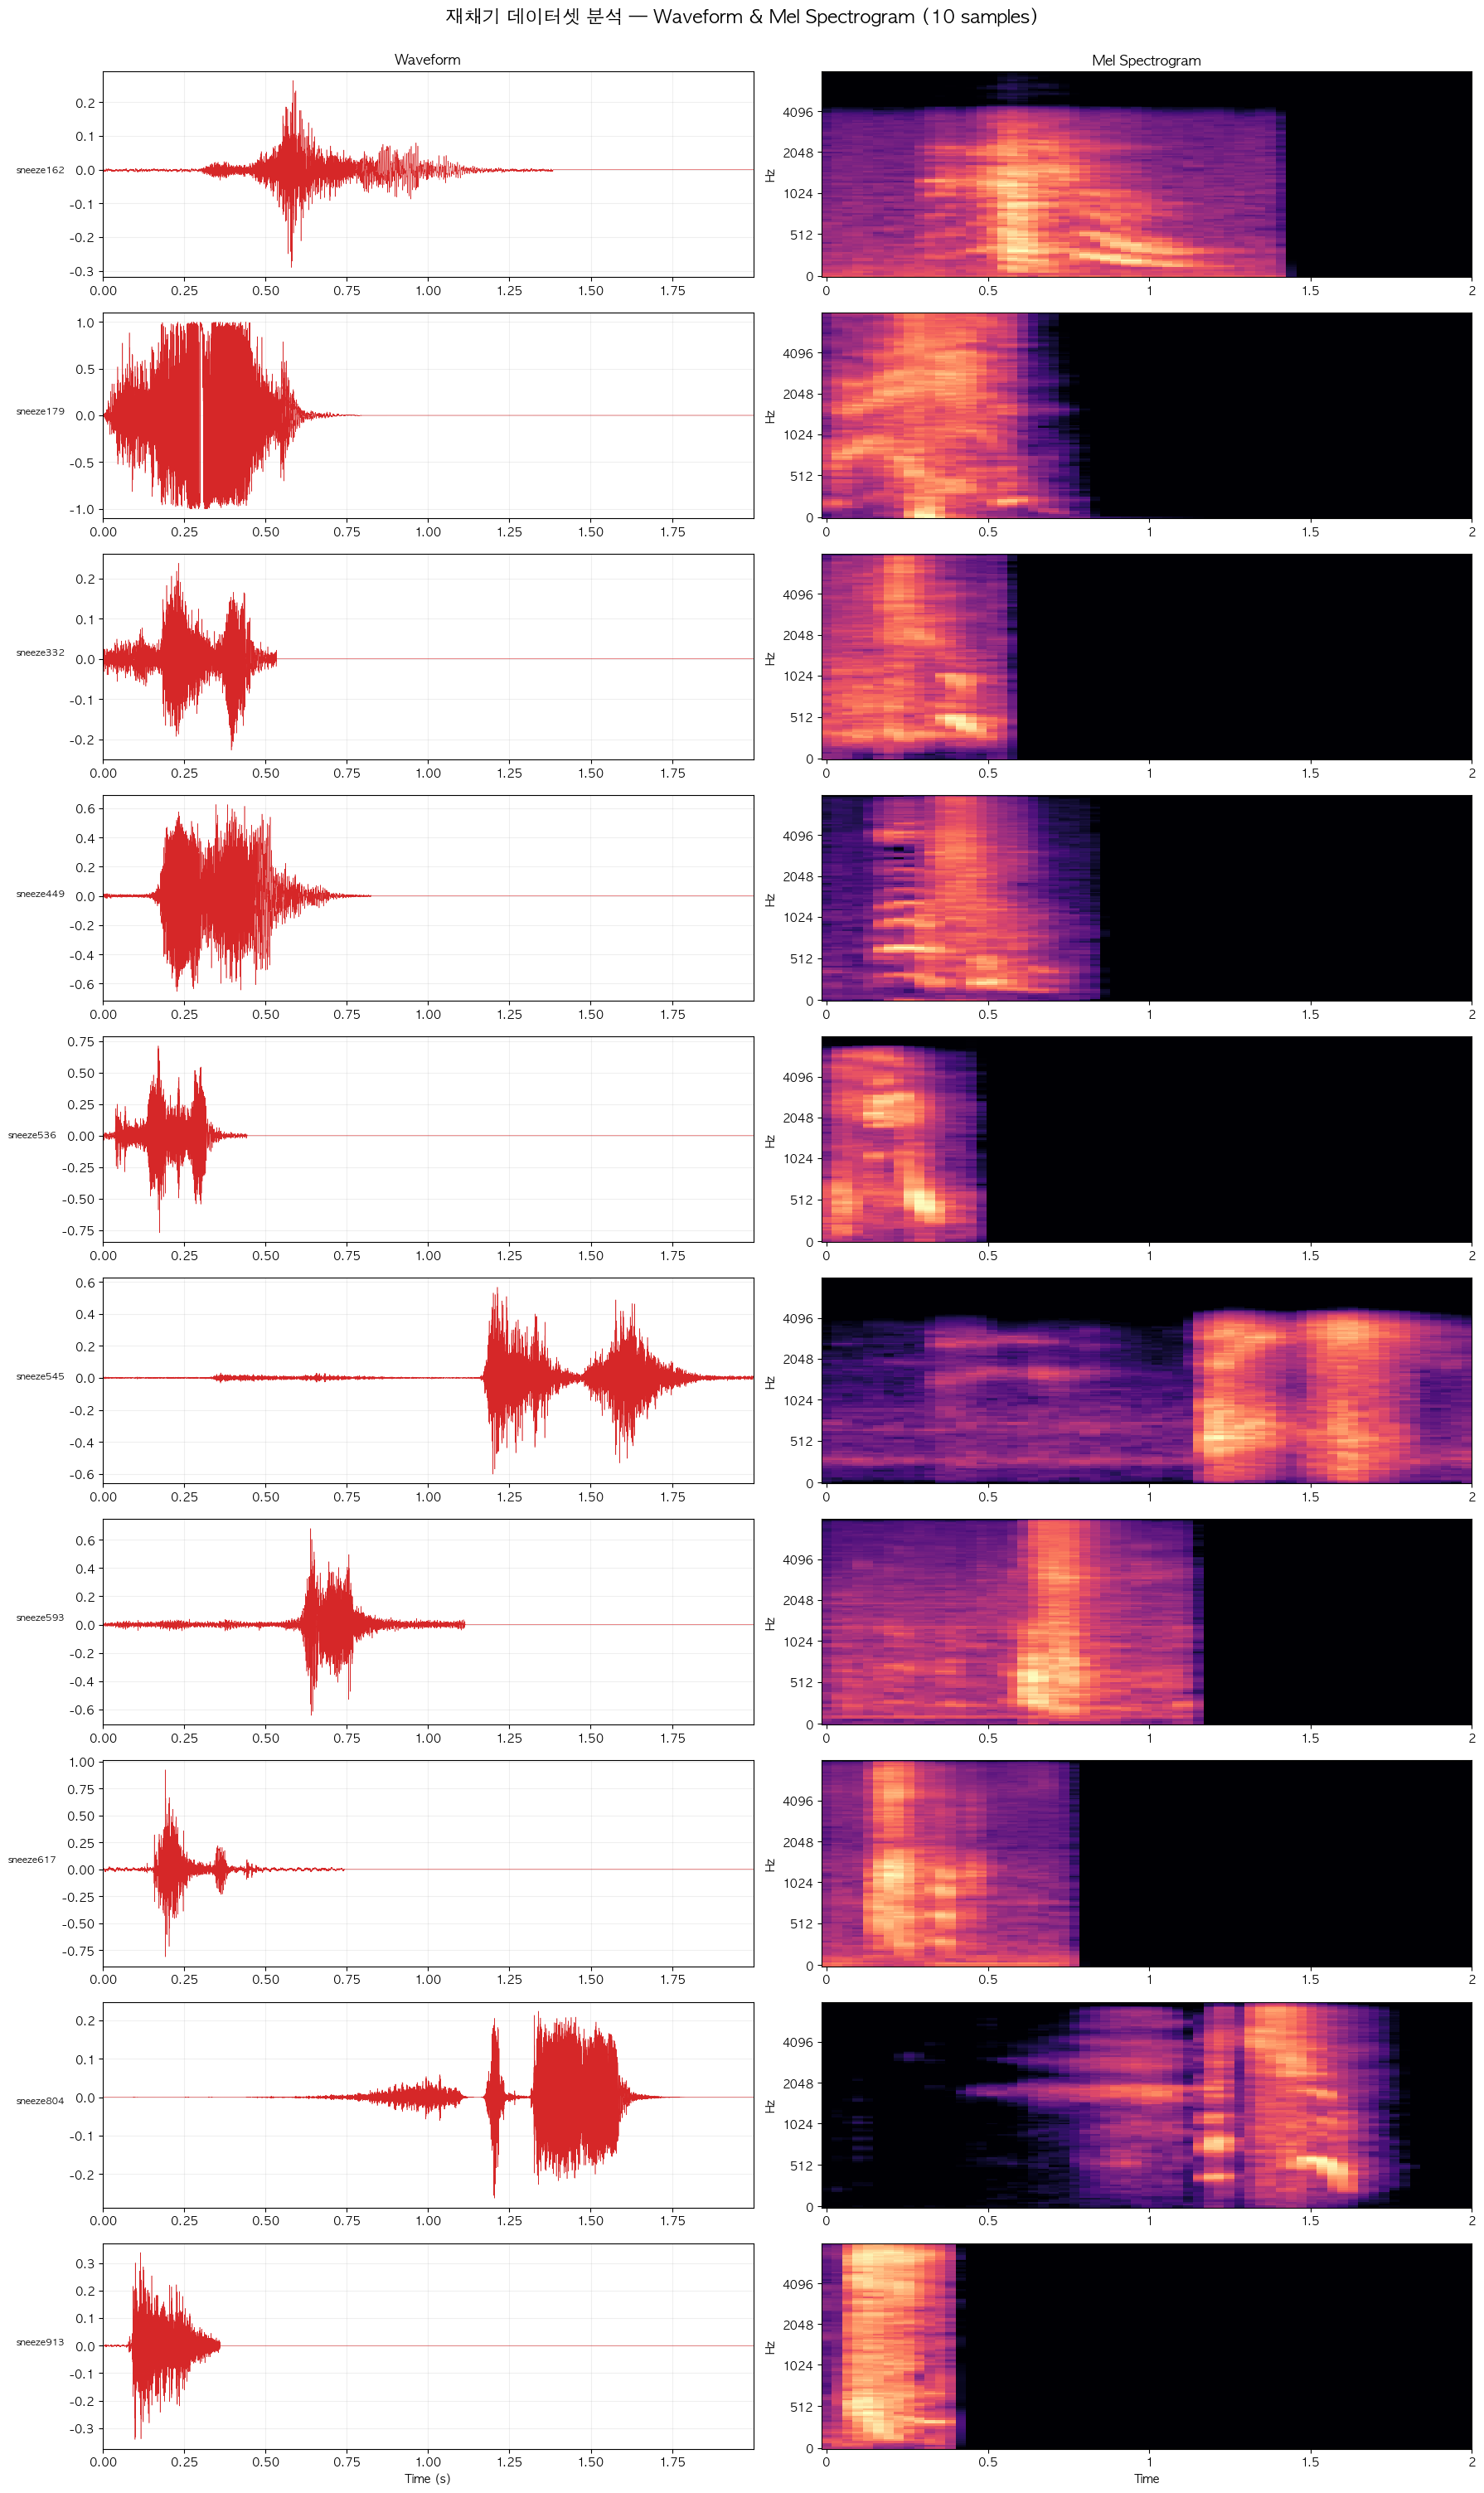

In [7]:
# ============================================================
# 재채기 10개 샘플: Waveform + Mel Spectrogram
# ============================================================

fig, axes = plt.subplots(10, 2, figsize=(18, 30))
fig.suptitle("재채기 데이터셋 분석 — Waveform & Mel Spectrogram (10 samples)", 
             fontsize=16, fontweight='bold', y=1.001)

for i, (fname, audio) in enumerate(sneeze_audios.items()):
    t = np.arange(len(audio)) / sr_target
    
    # Waveform
    axes[i, 0].plot(t, audio, linewidth=0.4, color='tab:red')
    axes[i, 0].set_ylabel(fname.replace('.wav',''), fontsize=8, rotation=0, ha='right')
    axes[i, 0].set_xlim(0, t[-1])
    axes[i, 0].grid(True, alpha=0.2)
    if i == 0:
        axes[i, 0].set_title("Waveform", fontsize=12, fontweight='bold')
    if i == len(sneeze_audios) - 1:
        axes[i, 0].set_xlabel("Time (s)")
    
    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr_target, n_mels=128, fmax=sr_target//2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr_target, x_axis='time', y_axis='mel',
                              ax=axes[i, 1], cmap='magma')
    if i == 0:
        axes[i, 1].set_title("Mel Spectrogram", fontsize=12, fontweight='bold')
    if i < len(sneeze_audios) - 1:
        axes[i, 1].set_xlabel("")

plt.tight_layout()
plt.show()

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_45294/790762331.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = axes[2].boxplot(bp_data, labels=list(bands.keys()), patch_artist=True, widths=0.6)


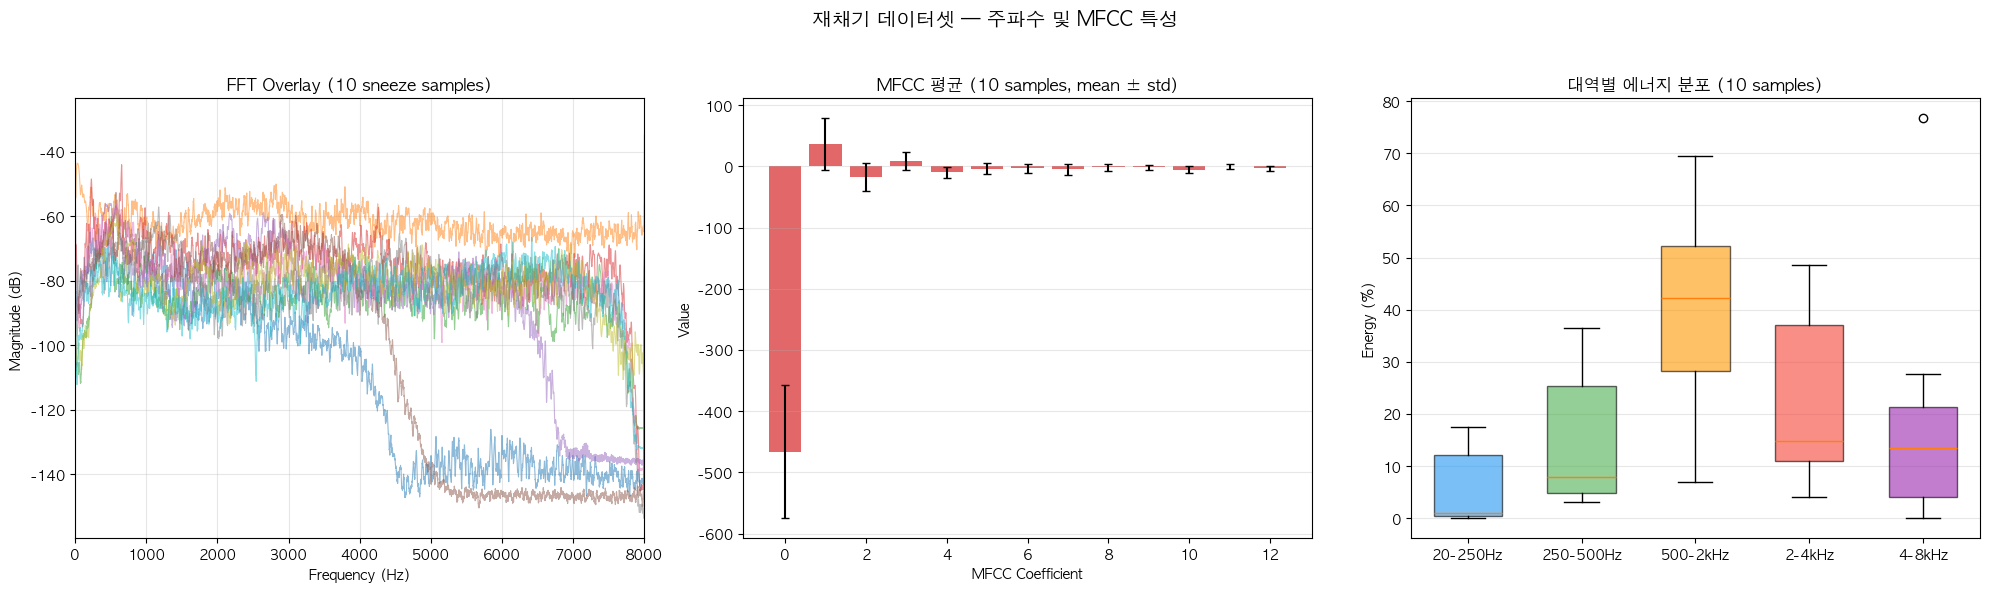


재채기 대역별 에너지 분포 (%) — 평균 ± 표준편차:
  20-250Hz    :   5.63% ±  7.06%
  250-500Hz   :  14.66% ± 11.84%
  500-2kHz    :  39.32% ± 18.27%
  2-4kHz      :  21.66% ± 15.78%
  4-8kHz      :  18.40% ± 21.42%


In [8]:
# ============================================================
# 재채기 10개 샘플: FFT 오버레이 + MFCC 평균 패턴
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("재채기 데이터셋 — 주파수 및 MFCC 특성", fontsize=14, fontweight='bold')

# (1) FFT 오버레이 — 모든 재채기 샘플
for fname, audio in sneeze_audios.items():
    N = len(audio)
    fft_mag = np.abs(np.fft.rfft(audio)) / N
    fft_freq = np.fft.rfftfreq(N, d=1/sr_target)
    fft_dB = 20 * np.log10(fft_mag + 1e-10)
    # smoothing
    win = 30
    fft_smooth = np.convolve(fft_dB, np.ones(win)/win, mode='same')
    axes[0].plot(fft_freq, fft_smooth, linewidth=0.8, alpha=0.5)

axes[0].set_title("FFT Overlay (10 sneeze samples)")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Magnitude (dB)")
axes[0].set_xlim(0, sr_target // 2)
axes[0].grid(True, alpha=0.3)

# (2) MFCC 평균 + 표준편차 (13계수)
all_mfcc_means = []
for fname, audio in sneeze_audios.items():
    mfcc = librosa.feature.mfcc(y=audio, sr=sr_target, n_mfcc=13)
    all_mfcc_means.append(mfcc.mean(axis=1))

mfcc_arr = np.array(all_mfcc_means)
mfcc_mean = mfcc_arr.mean(axis=0)
mfcc_std = mfcc_arr.std(axis=0)

x = np.arange(13)
axes[1].bar(x, mfcc_mean, yerr=mfcc_std, color='tab:red', alpha=0.7, capsize=3)
axes[1].set_title("MFCC 평균 (10 samples, mean ± std)")
axes[1].set_xlabel("MFCC Coefficient")
axes[1].set_ylabel("Value")
axes[1].grid(True, alpha=0.3, axis='y')

# (3) 대역별 에너지 분포 통계
bands = {"20-250Hz": (20, 250), "250-500Hz": (250, 500), "500-2kHz": (500, 2000),
         "2-4kHz": (2000, 4000), "4-8kHz": (4000, 8000)}

all_band_pcts = {b: [] for b in bands}
for fname, audio in sneeze_audios.items():
    N = len(audio)
    fft_pow = np.abs(np.fft.rfft(audio)) ** 2
    fft_freq = np.fft.rfftfreq(N, d=1/sr_target)
    total = np.sum(fft_pow) + 1e-10
    for bname, (lo, hi) in bands.items():
        mask = (fft_freq >= lo) & (fft_freq < hi)
        all_band_pcts[bname].append(np.sum(fft_pow[mask]) / total * 100)

bp_data = [all_band_pcts[b] for b in bands]
bplot = axes[2].boxplot(bp_data, labels=list(bands.keys()), patch_artist=True, widths=0.6)
colors_bp = ['#2196F3', '#4CAF50', '#FF9800', '#F44336', '#9C27B0']
for patch, color in zip(bplot['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[2].set_title("대역별 에너지 분포 (10 samples)")
axes[2].set_ylabel("Energy (%)")
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 수치 요약
print("\n재채기 대역별 에너지 분포 (%) — 평균 ± 표준편차:")
for bname in bands:
    vals = all_band_pcts[bname]
    print(f"  {bname:<12}: {np.mean(vals):6.2f}% ± {np.std(vals):5.2f}%")

### Step 2: 합성 고주파 노이즈 생성 및 재채기와 비교

다양한 유형의 고주파 노이즈를 합성하여 재채기 신호와 어떤 차이가 있는지 직접 비교합니다.

In [9]:
# ============================================================
# Step 2: 합성 고주파 노이즈 생성
# ============================================================
# 모델이 혼동할 수 있는 다양한 고주파 신호를 생성

duration = 2.0  # 2초 (모델 입력 길이와 동일)
sr = sr_target
n_samples = int(sr * duration)
t = np.arange(n_samples) / sr

# (1) White noise burst — 짧은 고에너지 충격 (snap/clap과 유사)
white_burst = np.zeros(n_samples)
burst_start = int(0.3 * sr)
burst_len = int(0.05 * sr)  # 50ms burst
white_burst[burst_start:burst_start+burst_len] = np.random.randn(burst_len) * 0.5
# decay tail
decay_len = int(0.1 * sr)
decay = np.exp(-np.linspace(0, 5, decay_len))
white_burst[burst_start+burst_len:burst_start+burst_len+decay_len] += \
    np.random.randn(decay_len) * 0.1 * decay

# (2) High-freq sine burst — 4kHz 순음 burst
hf_sine = np.zeros(n_samples)
hf_start = int(0.3 * sr)
hf_len = int(0.1 * sr)  # 100ms
hf_sine[hf_start:hf_start+hf_len] = 0.5 * np.sin(2 * np.pi * 4000 * t[:hf_len])
# envelope
env = np.exp(-np.linspace(0, 3, hf_len))
hf_sine[hf_start:hf_start+hf_len] *= env

# (3) Broadband impulse — 디랙 델타 유사 (매우 짧은 충격)
impulse = np.zeros(n_samples)
imp_pos = int(0.3 * sr)
impulse[imp_pos] = 1.0
# 약간의 반향 추가
for delay, amp in [(80, 0.3), (200, 0.15), (400, 0.08)]:
    if imp_pos + delay < n_samples:
        impulse[imp_pos + delay] = amp

# (4) Pink noise (지속형) — 저주파 강조된 노이즈
white = np.random.randn(n_samples)
fft_white = np.fft.rfft(white)
freqs = np.fft.rfftfreq(n_samples, d=1/sr)
freqs[0] = 1  # avoid div by zero
pink_filter = 1 / np.sqrt(freqs)
pink_noise = np.fft.irfft(fft_white * pink_filter, n=n_samples)
pink_noise = pink_noise / np.max(np.abs(pink_noise)) * 0.3

synth_sounds = {
    "White Burst\n(snap-like)": white_burst,
    "HF Sine Burst\n(4kHz)": hf_sine,
    "Impulse\n(click-like)": impulse,
    "Pink Noise\n(continuous)": pink_noise,
}

# 대표 재채기 1개 선택
ref_sneeze_name = list(sneeze_audios.keys())[0]
ref_sneeze = sneeze_audios[ref_sneeze_name]
# 2초로 자르기
if len(ref_sneeze) > n_samples:
    ref_sneeze = ref_sneeze[:n_samples]
elif len(ref_sneeze) < n_samples:
    ref_sneeze = np.pad(ref_sneeze, (0, n_samples - len(ref_sneeze)))

print("합성 고주파 노이즈 4종 생성 완료")
for name, audio in synth_sounds.items():
    n = name.replace('\n', ' ')
    print(f"  {n:<25}: peak={np.max(np.abs(audio)):.4f}, rms={np.sqrt(np.mean(audio**2)):.4f}")
print(f"  참조 재채기: {ref_sneeze_name}")

합성 고주파 노이즈 4종 생성 완료
  White Burst (snap-like)  : peak=1.4481, rms=0.0789
  HF Sine Burst (4kHz)     : peak=0.4991, rms=0.0322
  Impulse (click-like)     : peak=1.0000, rms=0.0059
  Pink Noise (continuous)  : peak=0.3000, rms=0.0776
  참조 재채기: sneeze162.wav


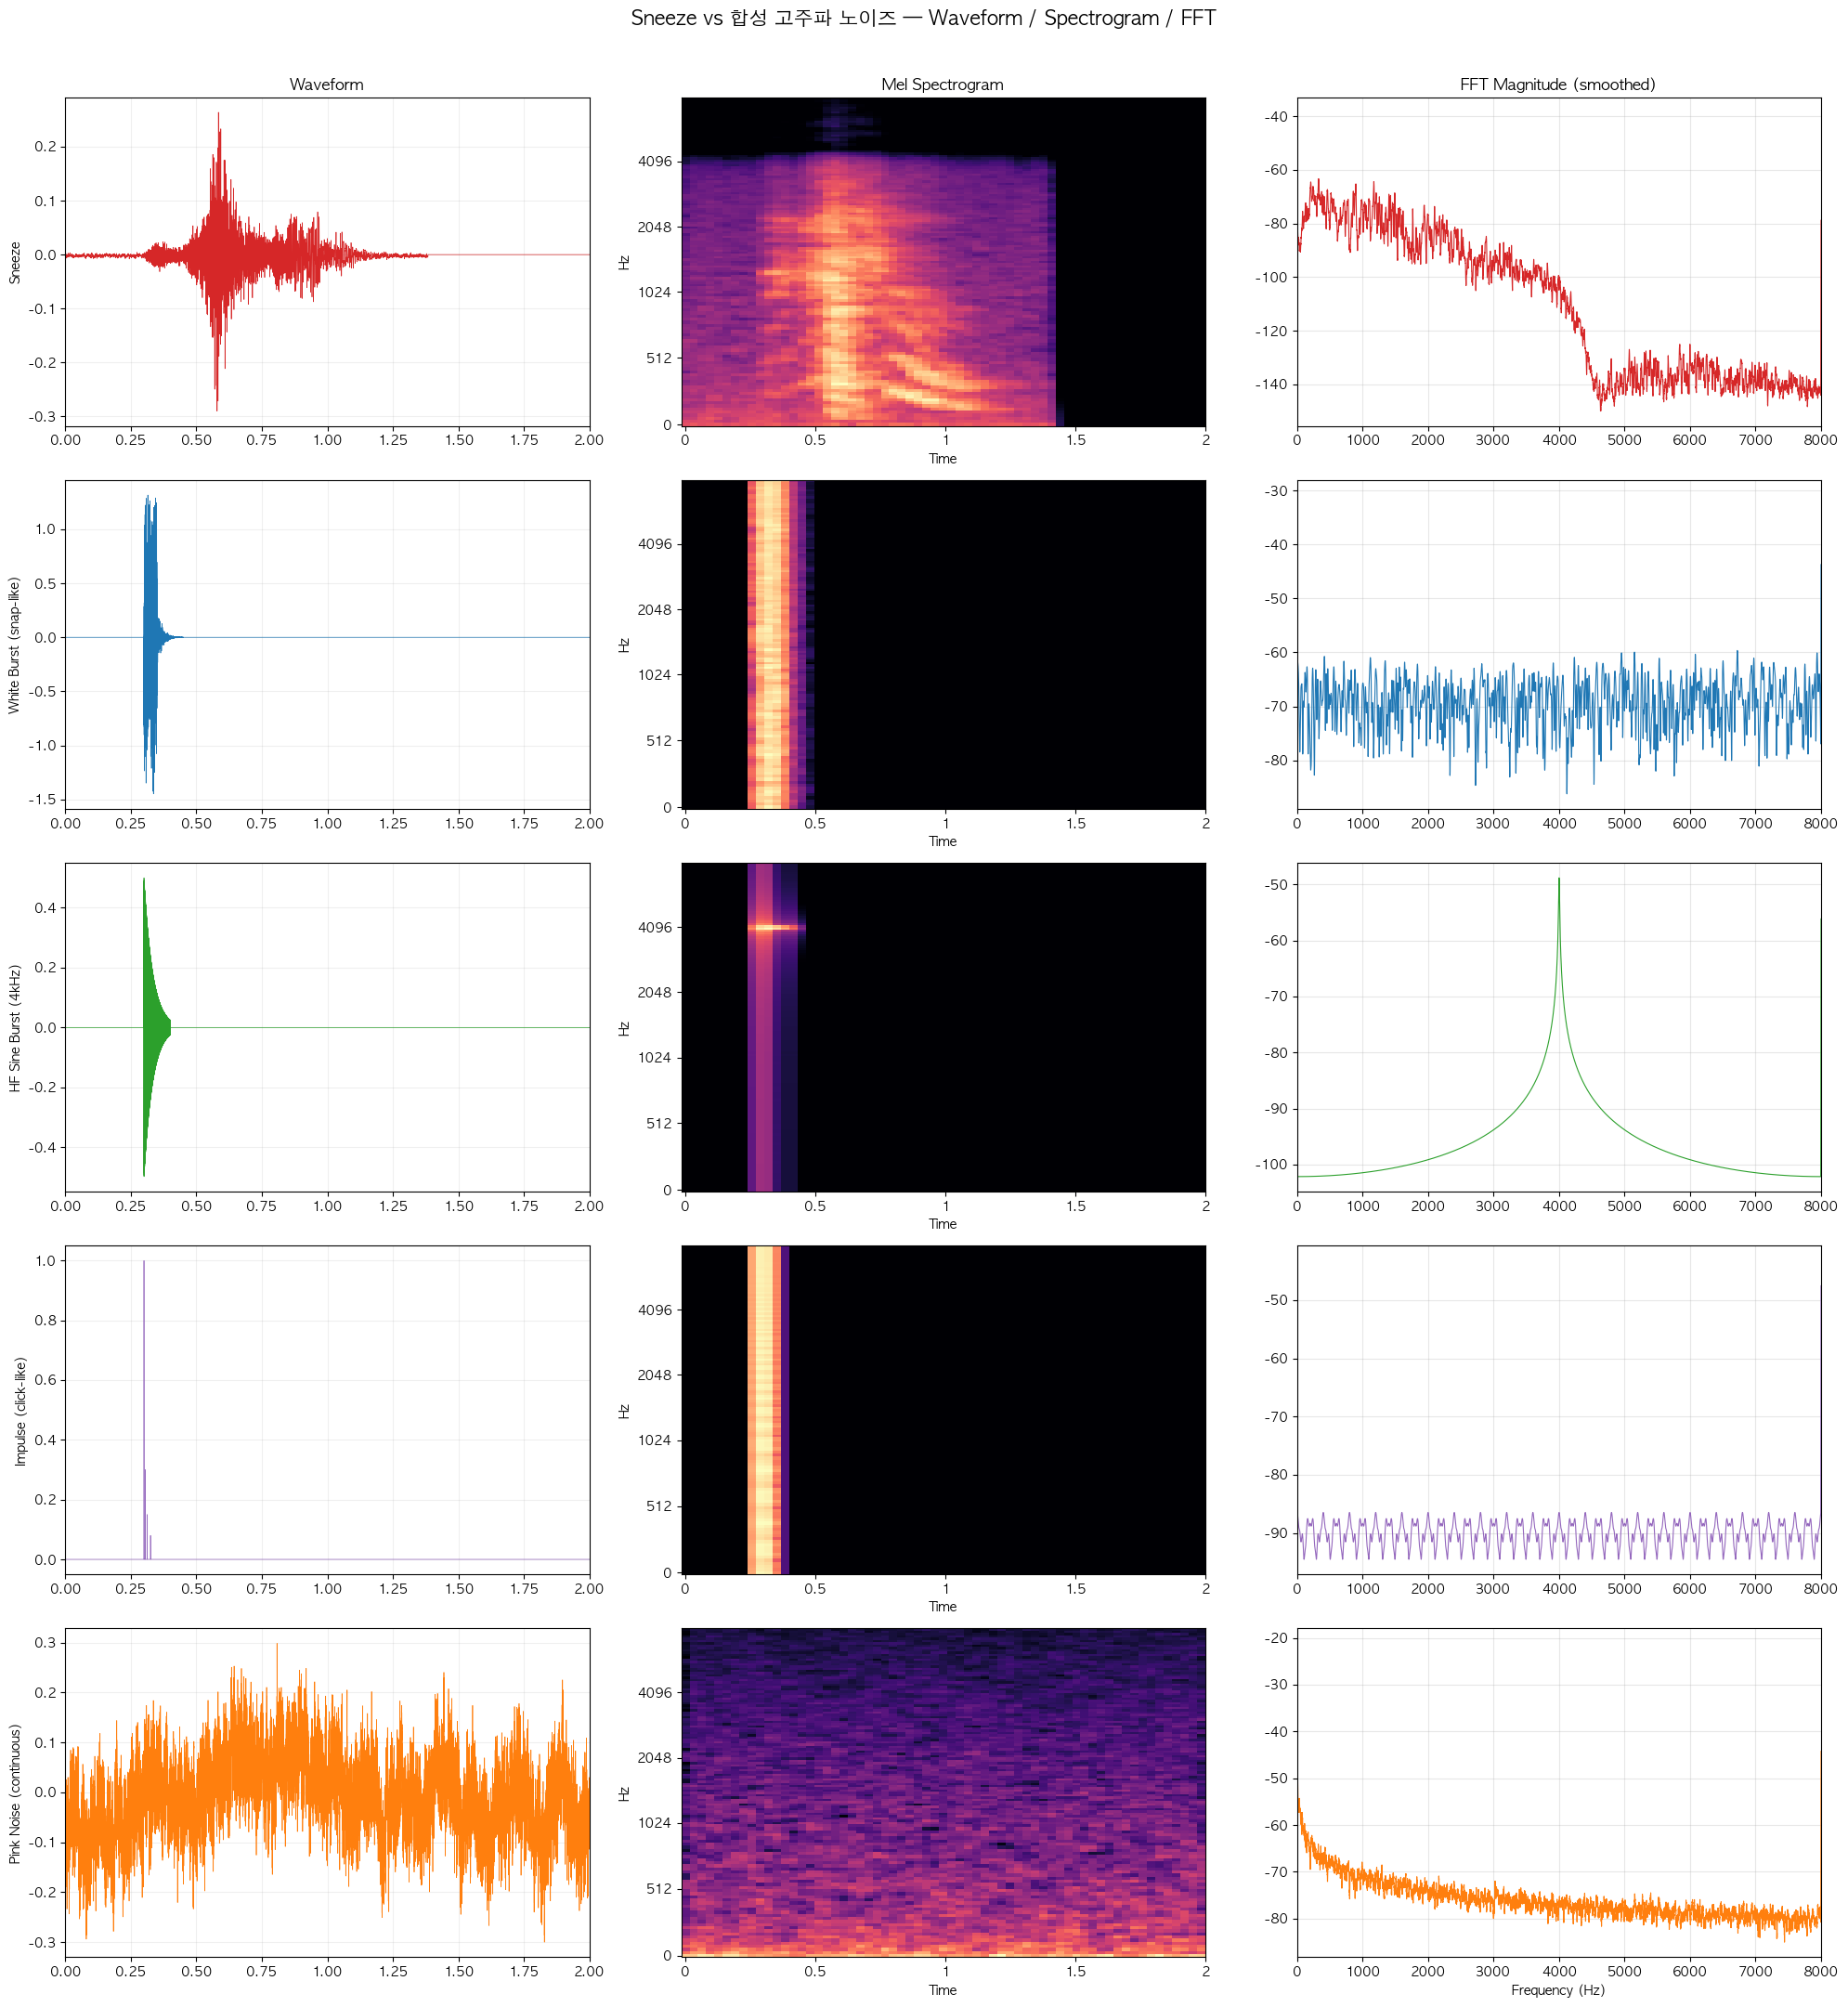

In [10]:
# ============================================================
# 재채기 vs 합성 노이즈 4종: Waveform + Spectrogram + FFT 비교
# ============================================================

all_compare = {"Sneeze": ref_sneeze}
all_compare.update({k.replace('\n',' '): v for k, v in synth_sounds.items()})

fig, axes = plt.subplots(5, 3, figsize=(20, 22))
fig.suptitle("Sneeze vs 합성 고주파 노이즈 — Waveform / Spectrogram / FFT", 
             fontsize=15, fontweight='bold')

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange']

for i, (name, audio) in enumerate(all_compare.items()):
    color = colors[i]
    t_ax = np.arange(len(audio)) / sr
    
    # Waveform
    axes[i, 0].plot(t_ax, audio, linewidth=0.5, color=color)
    axes[i, 0].set_ylabel(name, fontsize=10, fontweight='bold')
    axes[i, 0].set_xlim(0, duration)
    axes[i, 0].grid(True, alpha=0.2)
    if i == 0:
        axes[i, 0].set_title("Waveform", fontsize=12)
    
    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=sr//2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel',
                              ax=axes[i, 1], cmap='magma')
    if i == 0:
        axes[i, 1].set_title("Mel Spectrogram", fontsize=12)
    
    # FFT
    N = len(audio)
    fft_mag = np.abs(np.fft.rfft(audio)) / N
    fft_freq = np.fft.rfftfreq(N, d=1/sr)
    fft_dB = 20 * np.log10(fft_mag + 1e-10)
    win = 20
    fft_smooth = np.convolve(fft_dB, np.ones(win)/win, mode='same')
    axes[i, 2].plot(fft_freq, fft_smooth, linewidth=0.8, color=color)
    axes[i, 2].set_xlim(0, sr // 2)
    axes[i, 2].grid(True, alpha=0.3)
    if i == 0:
        axes[i, 2].set_title("FFT Magnitude (smoothed)", fontsize=12)
    if i == len(all_compare) - 1:
        axes[i, 2].set_xlabel("Frequency (Hz)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Step 3: Snap + 합성 노이즈 + 재채기 정량적 비교

대역별 에너지, Spectral 특성, 시간적 특성을 수치로 비교합니다.

In [11]:
# ============================================================
# Step 3: 정량적 비교 — Sneeze(10개 평균) vs Snap vs 합성 노이즈
# ============================================================

# Snap 로드
snap_audio, snap_sr_orig = torchaudio.load('data_analysis/snap.wav')
if snap_sr_orig != sr_target:
    snap_audio = torchaudio.transforms.Resample(int(snap_sr_orig), sr_target)(snap_audio)
snap_np = snap_audio.numpy().flatten()
if len(snap_np) > n_samples:
    snap_np = snap_np[:n_samples]
elif len(snap_np) < n_samples:
    snap_np = np.pad(snap_np, (0, n_samples - len(snap_np)))

# Feature 추출 함수
def compute_features(audio, sr):
    feat = {}
    # 대역별 에너지
    N = len(audio)
    fft_pow = np.abs(np.fft.rfft(audio)) ** 2
    fft_freq = np.fft.rfftfreq(N, d=1/sr)
    total = np.sum(fft_pow) + 1e-10
    for bname, (lo, hi) in [("20-250Hz", (20,250)), ("250-500Hz", (250,500)),
                              ("500-2kHz", (500,2000)), ("2-4kHz", (2000,4000)),
                              ("4-8kHz", (4000,8000))]:
        mask = (fft_freq >= lo) & (fft_freq < hi)
        feat[bname] = np.sum(fft_pow[mask]) / total * 100
    
    # Spectral features
    feat['Centroid'] = float(librosa.feature.spectral_centroid(y=audio, sr=sr).mean())
    feat['Bandwidth'] = float(librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean())
    feat['Rolloff'] = float(librosa.feature.spectral_rolloff(y=audio, sr=sr).mean())
    feat['Flatness'] = float(librosa.feature.spectral_flatness(y=audio).mean())
    feat['ZCR'] = float(librosa.feature.zero_crossing_rate(audio).mean())
    
    # Temporal
    rms = librosa.feature.rms(y=audio)[0]
    if rms.max() > 0:
        rms_norm = rms / rms.max()
        feat['Attack(ms)'] = float(librosa.frames_to_time(np.argmax(rms_norm >= 0.9), sr=sr) * 1000)
        active = rms_norm >= 0.1
        if np.any(active):
            s = librosa.frames_to_time(np.argmax(active), sr=sr)
            e = librosa.frames_to_time(len(active) - np.argmax(active[::-1]) - 1, sr=sr)
            feat['Duration(ms)'] = float((e - s) * 1000)
        else:
            feat['Duration(ms)'] = 0.0
    else:
        feat['Attack(ms)'] = 0.0
        feat['Duration(ms)'] = 0.0
    
    return feat

# 재채기 10개 평균
sneeze_feats_list = [compute_features(a, sr_target) for a in sneeze_audios.values()]
sneeze_avg = {}
for key in sneeze_feats_list[0]:
    vals = [f[key] for f in sneeze_feats_list]
    sneeze_avg[key] = (np.mean(vals), np.std(vals))

# 나머지
snap_feat = compute_features(snap_np, sr_target)
synth_feats = {}
for name, audio in synth_sounds.items():
    synth_feats[name.replace('\n',' ')] = compute_features(audio, sr_target)

# ── 표 출력 ──
print("=" * 100)
print(f"{'Feature':<16} {'Sneeze(avg±std)':<22} {'Snap':<12}", end="")
for sn in synth_feats:
    print(f" {sn:<16}", end="")
print()
print("-" * 100)

for key in sneeze_avg:
    avg, std = sneeze_avg[key]
    print(f"{key:<16} {avg:>8.2f} ± {std:<8.2f}", end="")
    print(f" {snap_feat[key]:>10.2f}", end="")
    for sn, sf in synth_feats.items():
        print(f" {sf[key]:>14.2f}", end="")
    print()
print("=" * 100)

Feature          Sneeze(avg±std)        Snap         White Burst (snap-like) HF Sine Burst (4kHz) Impulse (click-like) Pink Noise (continuous)
----------------------------------------------------------------------------------------------------
20-250Hz             5.63 ± 7.06          22.22           2.72           0.01           2.93          21.57
250-500Hz           14.66 ± 11.84          1.92           3.69           0.01           2.91           5.79
500-2kHz            39.32 ± 18.27          2.67          18.31           0.05          18.72          12.10
2-4kHz              21.66 ± 15.78         17.68          22.73          48.43          25.00           6.09
4-8kHz              18.40 ± 21.42         54.97          51.75          51.51          49.99           6.11
Centroid          1227.58 ± 620.91      1033.88         571.33         444.44         317.46        2624.52
Bandwidth          926.70 ± 392.77      1310.11         335.97         119.32         183.56        2391.15


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

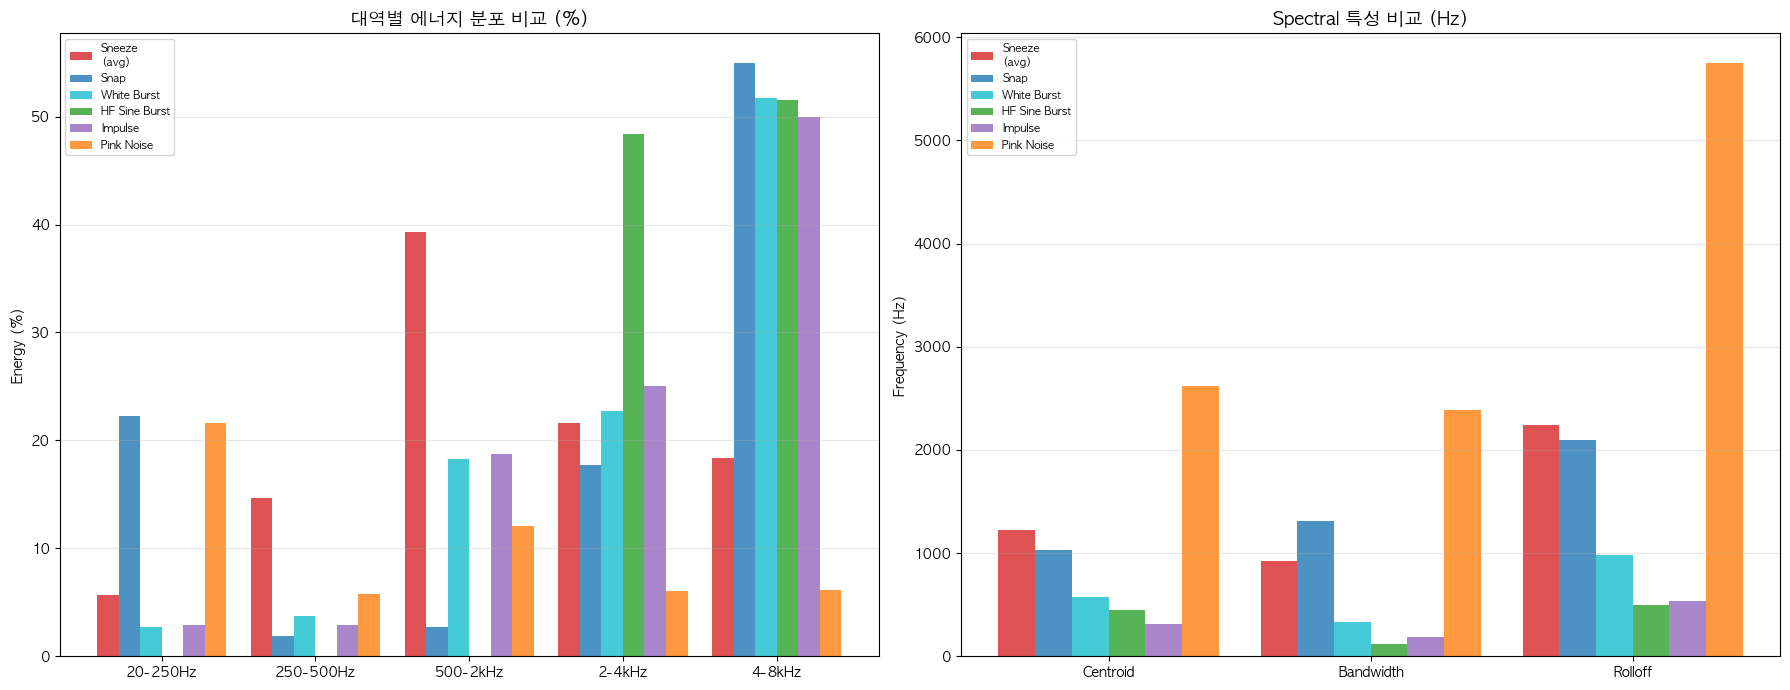

In [12]:
# ============================================================
# 시각적 비교: 대역별 에너지 + Spectral Features 바 차트
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ── (1) 대역별 에너지 비교 ──
band_keys = ["20-250Hz", "250-500Hz", "500-2kHz", "2-4kHz", "4-8kHz"]
labels = ["Sneeze\n(avg)", "Snap"] + [n.replace('\n',' ').split('(')[0].strip() for n in synth_sounds.keys()]

data_matrix = []
# Sneeze avg
data_matrix.append([sneeze_avg[k][0] for k in band_keys])
# Snap
data_matrix.append([snap_feat[k] for k in band_keys])
# Synth
for sf in synth_feats.values():
    data_matrix.append([sf[k] for k in band_keys])

data_matrix = np.array(data_matrix)
x = np.arange(len(band_keys))
width = 0.14
colors_bar = ['tab:red', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:orange']

for i in range(len(labels)):
    offset = (i - len(labels)/2 + 0.5) * width
    axes[0].bar(x + offset, data_matrix[i], width, label=labels[i], 
                color=colors_bar[i], alpha=0.8)

axes[0].set_xticks(x)
axes[0].set_xticklabels(band_keys)
axes[0].set_title("대역별 에너지 분포 비교 (%)", fontsize=13, fontweight='bold')
axes[0].set_ylabel("Energy (%)")
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3, axis='y')

# ── (2) Spectral 특성 비교 ──
spec_keys = ['Centroid', 'Bandwidth', 'Rolloff']
spec_data = []
spec_data.append([sneeze_avg[k][0] for k in spec_keys])
spec_data.append([snap_feat[k] for k in spec_keys])
for sf in synth_feats.values():
    spec_data.append([sf[k] for k in spec_keys])
spec_data = np.array(spec_data)

x2 = np.arange(len(spec_keys))
for i in range(len(labels)):
    offset = (i - len(labels)/2 + 0.5) * width
    axes[1].bar(x2 + offset, spec_data[i], width, label=labels[i],
                color=colors_bar[i], alpha=0.8)

axes[1].set_xticks(x2)
axes[1].set_xticklabels(spec_keys)
axes[1].set_title("Spectral 특성 비교 (Hz)", fontsize=13, fontweight='bold')
axes[1].set_ylabel("Frequency (Hz)")
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 4: 분석 결과 정리 및 Feature Extraction 전략 논의

위 플롯과 수치 비교 결과를 실행한 뒤, 아래 항목을 확인해보세요.

#### 재채기 고유 특성 (예상)
- **주파수 분포**: 500Hz~2kHz 대역에 에너지 집중 (저-중주파 중심)
- **시간적 구조**: 초기 burst + 이어지는 aspiration (수백 ms 지속)
- **Spectral Centroid**: 상대적으로 낮음 (1~3kHz 범위)

#### 고주파 노이즈/Snap과의 차이점 (예상)
- **Snap/Impulse**: 전 대역에 걸쳐 균일하게 에너지 분포, 매우 짧은 duration
- **HF Sine**: 4kHz 이상에 에너지 집중, Spectral Centroid 매우 높음
- **Pink Noise**: 지속형이지만 spectral shape가 완전히 다름

#### Feature Extraction 개선 방향
실행 결과에서 **재채기와 고주파 노이즈를 가장 잘 구분하는 feature**를 확인하고,
이를 바탕으로 모델 입력 feature를 재설계할 수 있습니다.

가능한 전략:
1. **MFCC + 대역별 에너지 비율** — 고주파 에너지 비율이 높으면 재채기가 아님
2. **MFCC + Spectral Centroid/Rolloff** — 주파수 중심 위치로 구분
3. **MFCC + 시간 특성 (Duration, Attack)** — 너무 짧으면 재채기가 아님
4. **Mel-Spectrogram 직접 입력** — 시간-주파수 패턴 전체를 CNN이 학습

## 5. MFCC 특성 추출

In [13]:
def preprocess_audio(audio):
    rms = np.sqrt(np.mean(audio**2))
    if rms > 0:
        audio = audio / rms * 0.1
    pre_emphasis = 0.97
    audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    if len(audio_trimmed) < len(audio):
        audio_trimmed = np.pad(audio_trimmed, (0, len(audio) - len(audio_trimmed)))
    elif len(audio_trimmed) > len(audio):
        audio_trimmed = audio_trimmed[:len(audio)]
    return audio_trimmed

def extract_mfcc_features(audio, n_mfcc=20, include_deltas=True):
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc, n_fft=2048, hop_length=512)
    mfcc = mfcc - np.mean(mfcc, axis=1, keepdims=True)
    if include_deltas:
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc = np.vstack([mfcc, delta, delta2])
    return mfcc

# MFCC 추출
print("MFCC 추출 중...")
mfcc_sneeze = []
for a in tqdm(all_sneeze, desc="Sneeze MFCC"):
    mfcc_sneeze.append(extract_mfcc_features(preprocess_audio(a)))

mfcc_life = []
for a in tqdm(all_life_noise, desc="Life MFCC"):
    mfcc_life.append(extract_mfcc_features(preprocess_audio(a)))

print(f"MFCC shape: {mfcc_sneeze[0].shape}")

MFCC 추출 중...


Life MFCC: 100%|██████████| 9944/9944 [01:16<00:00, 129.67it/s]

MFCC shape: (60, 63)


## 6. 데이터 시각화

📊 MFCC 특징 비교 시각화


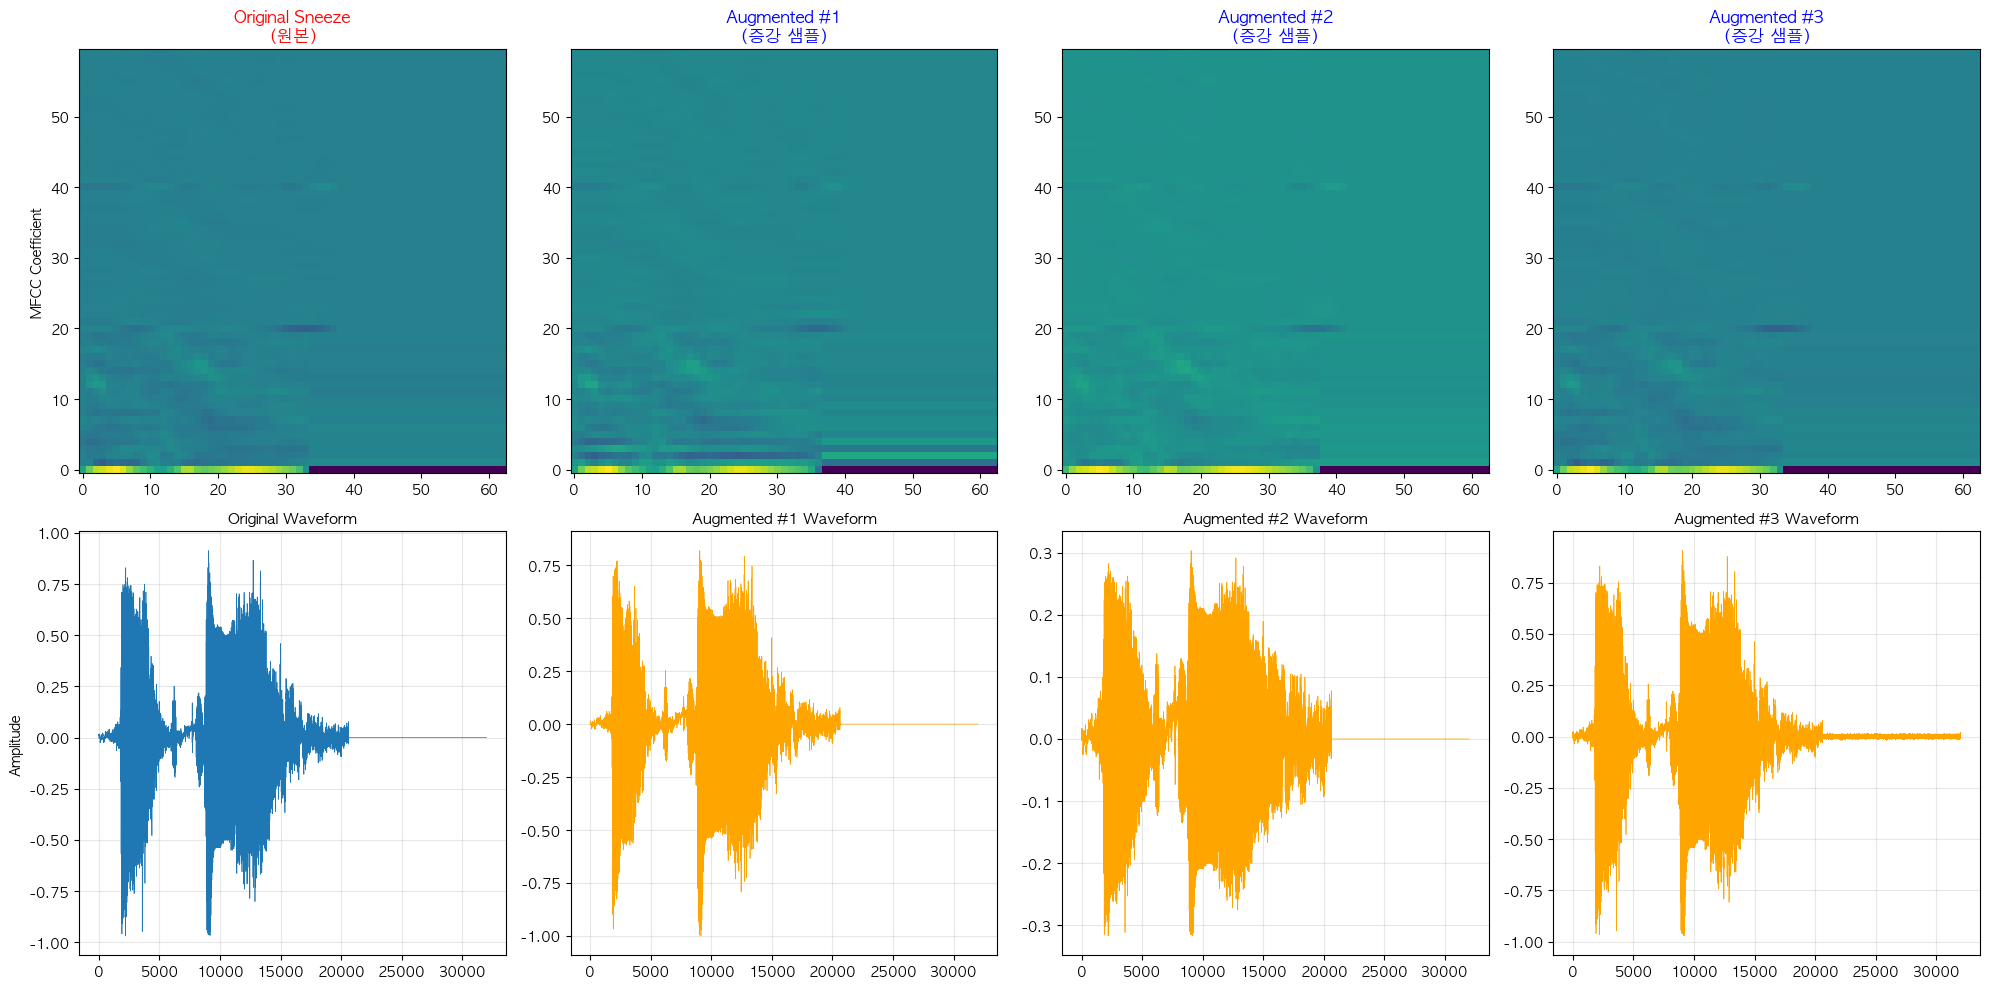


✅ MFCC 특징이 증강에 따라 다양해지는 것을 확인할 수 있습니다.
   이는 모델이 다양한 음향 변형에 대해 더 견고해지도록 합니다.


In [14]:
print("=" * 70)
print("📊 MFCC 특징 비교 시각화")
print("=" * 70)

# 원본과 증강된 샘플 비교
sample_idx = 0
original_audio = sneeze_samples[sample_idx]
augmented_audios = [
    sneeze_aug1[sample_idx],
    sneeze_aug2[sample_idx],
    sneeze_aug3[sample_idx]
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# 원본 MFCC
original_mfcc = extract_mfcc_features(preprocess_audio(original_audio))
axes[0, 0].imshow(original_mfcc, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title('Original Sneeze\n(원본)', fontweight='bold', color='red', fontsize=12)
axes[0, 0].set_ylabel('MFCC Coefficient')

# 증강된 MFCC들
for i, aug_audio in enumerate(augmented_audios):
    aug_mfcc = extract_mfcc_features(preprocess_audio(aug_audio))
    axes[0, i+1].imshow(aug_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[0, i+1].set_title(f'Augmented #{i+1}\n(증강 샘플)', fontweight='bold', color='blue', fontsize=12)

# 원본 파형
axes[1, 0].plot(original_audio, linewidth=0.5)
axes[1, 0].set_title('Original Waveform', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)

# 증강된 파형들
for i, aug_audio in enumerate(augmented_audios):
    axes[1, i+1].plot(aug_audio, linewidth=0.5, color='orange')
    axes[1, i+1].set_title(f'Augmented #{i+1} Waveform', fontweight='bold', fontsize=11)
    axes[1, i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ MFCC 특징이 증강에 따라 다양해지는 것을 확인할 수 있습니다.")
print("   이는 모델이 다양한 음향 변형에 대해 더 견고해지도록 합니다.")